# CHSH Inequality

This tutorial shows how to run the CHSH inequality experiment in Braket on local simulator and a QPU.   


# Background 

The CHSH (Clauser, Horne, Shimony and Holt) inequality is a generalization of Bell's inequality [3]. For a singlet state
$$|\psi ^{-}\rangle = \frac{1}{\sqrt{2}}\left(|+-\rangle + |-+\rangle \right )$$
the CHSH inequality is

$$
|P(a,b) - P(a,c)| + |P(d,b) + P(d,c)| \leq 2
$$
for measurement settings $a,d$ on the first particle and settings $b,c$ on the second particle. This reduces to Bell's original inequality if $d=b$.

## References 

[1]  Bell, J. S. On the Einstein Podolsky Rosen Paradox. Physics Physique Fizika 1, no. 3 (November 1, 1964): 195–200. https://doi.org/10.1103/PhysicsPhysiqueFizika.1.195. 

[2] Greenberger, Daniel M., Michael A. Horne, Abner Shimony, and Anton Zeilinger (1990). Bell’s Theorem without Inequalities. American Journal of Physics 58, no. 12: 1131–43. https://doi.org/10.1119/1.16243. 

[3] John F. Clauser, Michael A. Horne, Abner Shimony, and Richard A. Holt. Proposed Experiment to Test Local Hidden-Variable Theories. Phys. Rev. Lett. 23, 880 – Published 13 October 1969; Erratum Phys. Rev. Lett. 24, 549 (1970) https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.23.880

[4] The Nobel Committee for Physics, Scientific Background on the Nobel Prize in Physics 2022, https://www.nobelprize.org/uploads/2022/10/advanced-physicsprize2022.pdf

[5] John Preskill, Quantum Information and Computation, Chapter 4, Page 18, http://theory.caltech.edu/~preskill/ph229/notes/chap4_01.pdf

# Run on a local simulator

In [1]:
import numpy as np
from braket.devices import LocalSimulator
from braket.tracking import Tracker

from braket.experimental.algorithms.chsh_inequality import (
    create_chsh_inequality_circuits,
    run_chsh_inequality,
    get_chsh_results,
)

tracker = Tracker().start()  # to keep track of Braket costs

CHSH Inequality experiment consists of four circuits acting on two qubits each. The four circuits are grouped together in the `create_chsh_inequality_circuits` function below which takes as arguments the two qubits to act on and the four angles to rotate the first qubit by. The default values 
$$a = 0$$
$$b = \pi/4$$
$$c = 3\pi/4$$
$$d = \pi/2
$$
which gives maximum violation of the CHSH inequality. 

In [2]:
# CHSH reduces to Bell's original inequality with d==b
# circuits = create_chsh_inequality_circuits(a=0, b=np.pi/3, c=2*np.pi/3, d=np.pi/3)

# Maximum violation of CHSH inequality for singlet states
circuits = create_chsh_inequality_circuits(a=0, b=np.pi / 4, c=3 * np.pi / 4, d=np.pi / 2)

The circuits can be run on the Braket local simulator with:

In [3]:
local_tasks = run_chsh_inequality(circuits, LocalSimulator(), shots=0)

The results of the inequality experiment are called using the `get_chsh_results` function below.

In [4]:
chsh_value, results, Pab, Pac, Pdb, Pdc = get_chsh_results(local_tasks, verbose=True)

P(a,b) = -0.7071067811865474, P(a,c) = 0.7071067811865472, P(d,b) = -0.7071067811865475, P(d,c) = -0.7071067811865472

CHSH inequality: 2.828427124746189 ≤ 2
CHSH inequality is violated!
Notice that the quantity may not be exactly as predicted by Quantum theory. This is may be due to finite shots or the effects of noise on the QPU.


Notice the CHSH value is very close to $2\sqrt{2}\approx 2.828$. 

Below, we plot the CHSH value for various values of the angles. 

In [5]:
local_simulator = LocalSimulator()
angles = np.linspace(0, np.pi / 2, 100)

chsh_inequality_lhs_max = 0
chsh_inequality_lhs_max_theta = 0
chsh_values = []

for theta in angles:
    circuits = create_chsh_inequality_circuits(a=0, b=theta, c=3 * theta, d=2 * theta)
    local_tasks = run_chsh_inequality(circuits, local_simulator, shots=0)
    chsh_value, results, pAB, pAC, pDB, pDC = get_chsh_results(local_tasks, verbose=False)
    if chsh_value > chsh_inequality_lhs_max:
        chsh_inequality_lhs_max = abs(chsh_value)
        chsh_inequality_lhs_max_theta = theta
    chsh_values.append(chsh_value)

print(
    "\nFor all the iterations:\n Max CHSH_inequality:",
    chsh_inequality_lhs_max,
    "Corresponding theta:",
    chsh_inequality_lhs_max_theta,
)


For all the iterations:
 Max CHSH_inequality: 2.8281615256187003 Corresponding theta: 0.7774648486156559


Plotting the CHSH Value against theta angle to determine which theta gives maximum violation.

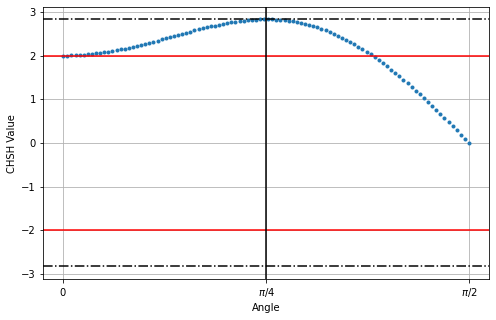

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(angles, chsh_values, ".", label="CHSH Value")

plt.grid(which="major", axis="both")
plt.axhline(y=2, color="r", linestyle="-")
plt.axhline(y=-2, color="r", linestyle="-")
plt.axvline(np.pi / 4, color="k", linestyle="-")
plt.axhline(y=np.sqrt(2) * 2, color="k", linestyle="-.")
plt.axhline(y=-np.sqrt(2) * 2, color="k", linestyle="-.")
plt.xticks([0, np.pi/4, np.pi/2], ["$0$", "$\pi/4$", "$\pi/2$"])
plt.xlabel("Angle")
plt.ylabel("CHSH Value");

From the plot, we see that the maximum violation is for $\theta = \pi/4$ as expected. The red line shows the classical bounds of $\text{CHSH} \leq 2$ and the dotted black line shows the quantum bound at $\text{CHSH} \leq 2\sqrt{2}$. 

# Run on a QPU

To run CHSH inequality on a QPU, we replace the LocalSimulator with an AwsDevice. 
To reduce the cost, we run the the experiment only for the theta which gave the maximum CHSH inequality value.

The cost to run this experiment is \$0.3 per task and \$0.00035 per shot on the Oxford Quantum Circuits Lucy device. Since we have four circuits of 1000 shots each, that totals \$2.60 USD.

In [7]:
# Uncomment the following to run on QPU
# from braket.aws import AwsDevice
# device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")
# circuits = create_chsh_inequality_circuits()
# tasks = run_chsh_inequality(circuits, device, shots=1_000)
# chsh_value, results, pAB, pAC, pDB, pDC = get_chsh_results(tasks)

We see that CHSH inequality is violated, so the device is demonstrating quantum behavior.

In [8]:
print(
    f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost() :.2f} USD"
)

Estimated cost to run this example: 0.00 USD


Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).